In [ ]:
# import libraries
import os
import shutil
from PIL import Image
import random
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Mounting Images

In [ ]:
# unzip file from stored google drive
# !unzip "/content/drive/My Drive/data/dataset.zip" -d "/content/pet_facial_expression"

In [ ]:
# !unzip "/content/drive/My Drive/data/paintings.zip" -d "/content/paintings"

In [ ]:
# specify the source of our images
source = ['pet_facial_expression/dataset/Angry', 'pet_facial_expression/dataset/Other', 'pet_facial_expression/dataset/Sad', 'pet_facial_expression/dataset/happy']

# fefine destination folder. create train A and testA which A is the Animal Image
trainA_folder = "/content/dataset/trainA"
testA_folder = "/content/dataset/testA"
os.makedirs(trainA_folder, exist_ok=True)
os.makedirs(testA_folder, exist_ok=True)

for folder in source:
    files = os.listdir(folder)
    random.shuffle(files)  # shuffle for randomness
    split_idx = int(len(files) * 0.8)  # 80% for training, 20% for testing

    for file in files[:split_idx]:  # Move 80% to trainA
        src_path = os.path.join(folder, file)
        dest_path = os.path.join(trainA_folder, file)
        shutil.copy(src_path, dest_path)

    for file in files[split_idx:]:  # Move 20% to testA
        src_path = os.path.join(folder, file)
        dest_path = os.path.join(testA_folder, file)
        shutil.copy(src_path, dest_path)

In [ ]:
# get the paintings on the paintings folder and input everything to trainB
paintings_folder = "/content/paintings/paintings"
trainB_folder = "/content/dataset/trainB"
os.makedirs(trainB_folder, exist_ok=True)

# Move paintings into trainB
for file in os.listdir(paintings_folder):
    src_path = os.path.join(paintings_folder, file)
    dest_path = os.path.join(trainB_folder, file)
    shutil.copy(src_path, dest_path)

In [ ]:
from PIL import Image

# resize images to 256x256 because CycleGAN works better with that size of images
def resize_images(folder):
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        img = Image.open(img_path).convert("RGB")
        img = img.resize((256, 256))
        img.save(img_path)

resize_images("/content/dataset/trainA")
resize_images("/content/dataset/testA")
resize_images("/content/dataset/trainB")

In [ ]:
# clone the github to get all of the file
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.git f

Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2516, done.
remote: Total 2516 (delta 0), reused 0 (delta 0), pack-reused 2516 (from 1)
Receiving objects: 100% (2516/2516), 8.20 MiB | 17.68 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.


In [ ]:
# look at the pytorch-CycleGAN-and-pix2pix folder
%cd pytorch-CycleGAN-and-pix2pix

/content/pytorch-CycleGAN-and-pix2pix


## Train the data

In [ ]:
# train it on the train.py file with 25 epochs (non decay) and 25 epochs on decay
!python train.py --dataroot /content/dataset --name animal2art --model cycle_gan --n_epochs 25 --n_epochs_decay 25

----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: /content/dataset              	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                        
              

In [ ]:
# set all of the images on trainB to be on testB as well
cp -r /content/dataset/trainB /content/dataset/testB

In [ ]:
# call the test.py file to do the style transfer based on the train model we have trained
!python test.py --dataroot /content/dataset --name animal2art --model cycle_gan --phase test --direction AtoB

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: /content/dataset              	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                            

## Check the result of CycleGAN

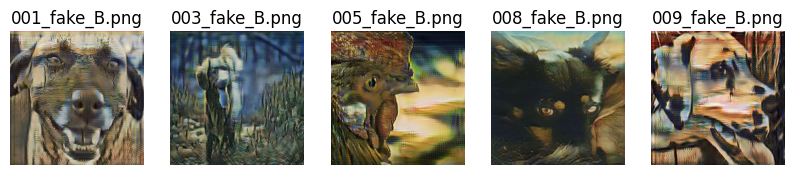

In [ ]:
# create a path to the result of the images
result_folder = "/content/pytorch-CycleGAN-and-pix2pix/results/animal2art/test_latest/images/"

# list of all images and get only the generated one specified by fake
generated_images = sorted([f for f in os.listdir(result_folder) if "_fake_B" in f])

# shop 5 images
num_images = min(5, len(generated_images))
plt.figure(figsize=(10, 5))
for i, img_name in enumerate(generated_images[:num_images]):
    img_path = os.path.join(result_folder, img_name)
    img = Image.open(img_path)
    plt.subplot(1, num_images, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(img_name)
plt.show()

real_A.png → Original animal image (input).

fake_B.png → Stylized painting of the animal (output).

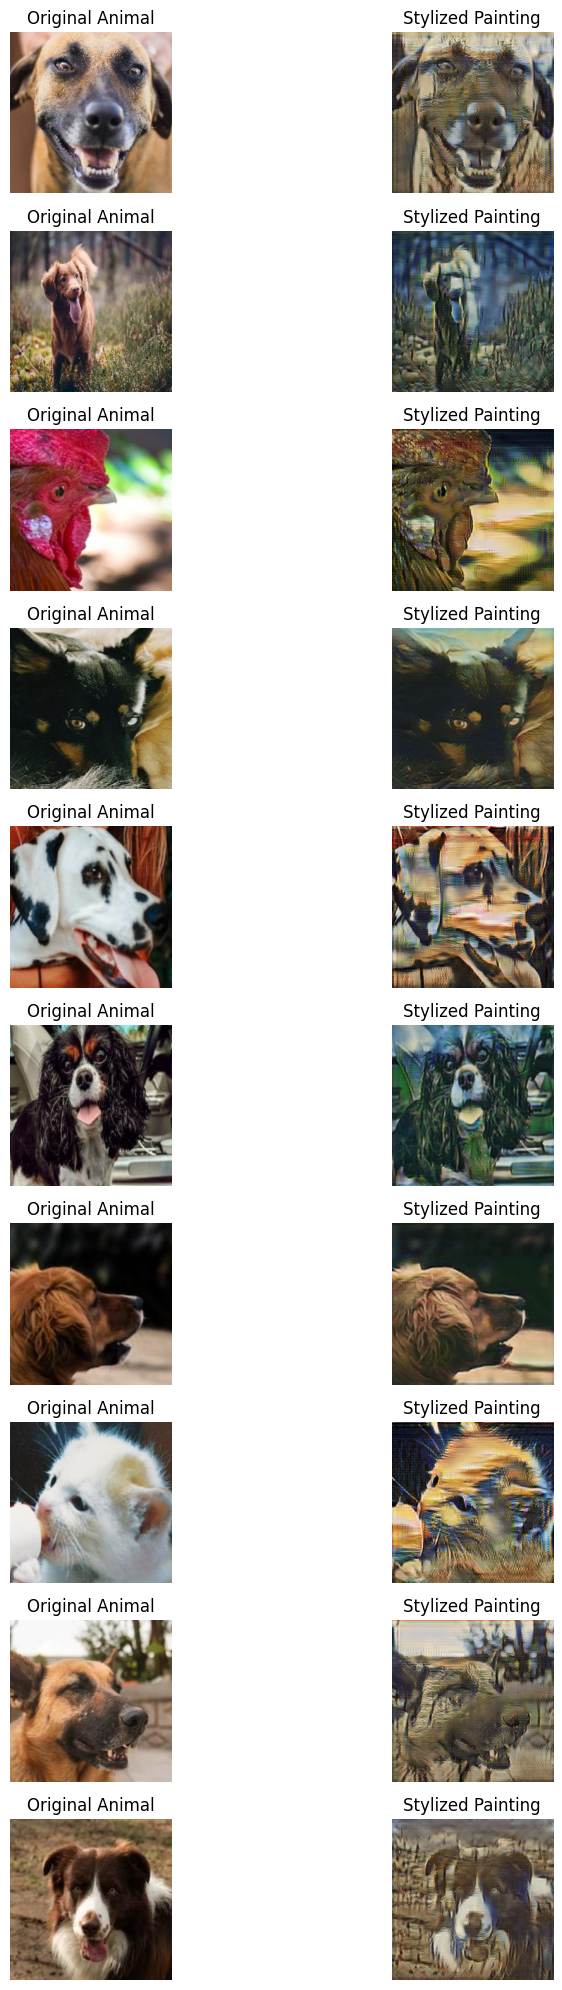

In [ ]:
# number of samples to show
num_samples = 10

plt.figure(figsize=(10, num_samples * 2))
for i, img_name in enumerate(generated_images[:num_samples]):
    real_img_name = img_name.replace("fake_B", "real_A")  # get the original animal image
    real_img_path = os.path.join(result_folder, real_img_name)
    fake_img_path = os.path.join(result_folder, img_name)

    # load images
    real_img = Image.open(real_img_path)
    fake_img = Image.open(fake_img_path)

    # show real image
    plt.subplot(num_samples, 2, 2 * i + 1)
    plt.imshow(real_img)
    plt.axis("off")
    plt.title("Original Animal")

    # show generated style-transferred image
    plt.subplot(num_samples, 2, 2 * i + 2)
    plt.imshow(fake_img)
    plt.axis("off")
    plt.title("Stylized Painting")

plt.tight_layout()
plt.show()

## Try to increase lambda and without epoch decay

In [ ]:
!python train.py --dataroot /content/dataset --name animal2art --model cycle_gan --n_epochs 50 --n_epochs_decay 0 --lambda_A 15 --lambda_B 15

----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: /content/dataset              	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                        
              

In [ ]:
cp -r /content/dataset/trainB /content/dataset/testB

In [ ]:
!python test.py --dataroot /content/dataset --name animal2art --model cycle_gan --phase test --direction AtoB

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: /content/dataset              	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                            

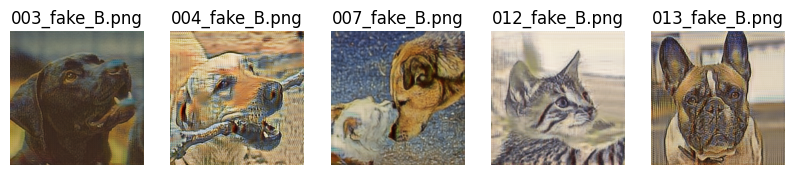

In [ ]:
# create a path to the result of the images
result_folder = "/content/pytorch-CycleGAN-and-pix2pix/results/animal2art/test_latest/images/"

# list of all images and get only the generated one specified by fake
generated_images = sorted([f for f in os.listdir(result_folder) if "_fake_B" in f])

# show 5 images
num_images = min(5, len(generated_images))
plt.figure(figsize=(10, 5))
for i, img_name in enumerate(generated_images[:num_images]):
    img_path = os.path.join(result_folder, img_name)
    img = Image.open(img_path)
    plt.subplot(1, num_images, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(img_name)
plt.show()

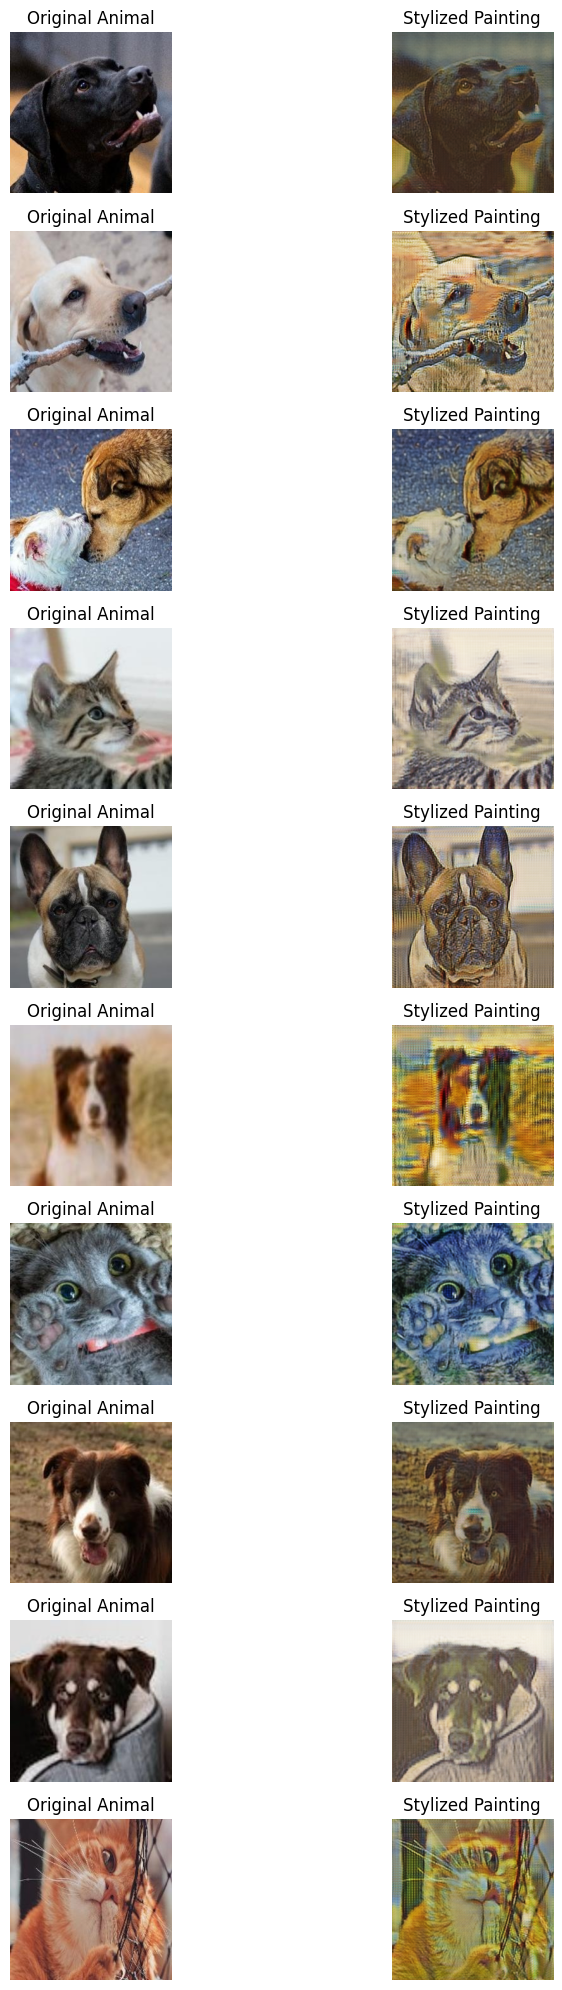

In [ ]:
# number of samples to show
num_samples = 10

plt.figure(figsize=(10, num_samples * 2))
for i, img_name in enumerate(generated_images[:num_samples]):
    real_img_name = img_name.replace("fake_B", "real_A")  # get the original animal image
    real_img_path = os.path.join(result_folder, real_img_name)
    fake_img_path = os.path.join(result_folder, img_name)

    # load images
    real_img = Image.open(real_img_path)
    fake_img = Image.open(fake_img_path)

    # show real image
    plt.subplot(num_samples, 2, 2 * i + 1)
    plt.imshow(real_img)
    plt.axis("off")
    plt.title("Original Animal")

    # show generated style-transferred image
    plt.subplot(num_samples, 2, 2 * i + 2)
    plt.imshow(fake_img)
    plt.axis("off")
    plt.title("Stylized Painting")

plt.tight_layout()
plt.show()

## Try with only 1 image on the B side

In [ ]:
trainB_folder = "/content/dataset/trainB"
os.makedirs(trainB_folder, exist_ok=True)

dest_path = os.path.join(trainB_folder, file)
shutil.copy("/content/the_starry_night.jpg", dest_path)

'/content/dataset/trainB/Katsushika Hokusai - Fine Breezy Day.jpg'

In [ ]:
from PIL import Image

# resize images to 256x256 because CycleGAN works better with that size of images
def resize_images(folder):
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        img = Image.open(img_path).convert("RGB")
        img = img.resize((256, 256))
        img.save(img_path)

resize_images("/content/dataset/trainA")
resize_images("/content/dataset/testA")
resize_images("/content/dataset/trainB")

In [ ]:
!python train.py --dataroot /content/dataset --name animal2art --model cycle_gan --n_epochs 50 --n_epochs_decay 0

----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: /content/dataset              	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                        
              

In [ ]:
cp -r /content/dataset/trainB /content/dataset/testB

In [ ]:
!python test.py --dataroot /content/dataset --name animal2art --model cycle_gan --phase test --direction AtoB

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: /content/dataset              	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                            

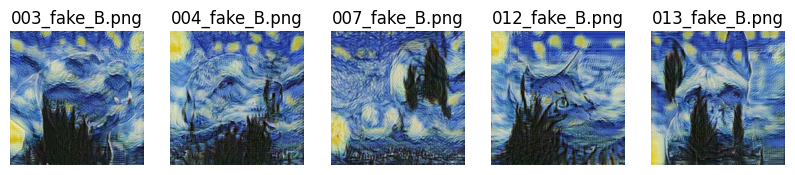

In [ ]:
# create a path to the result of the images
result_folder = "/content/pytorch-CycleGAN-and-pix2pix/results/animal2art/test_latest/images/"

# list of all images and get only the generated one specified by fake
generated_images = sorted([f for f in os.listdir(result_folder) if "_fake_B" in f])

# show 5 images
num_images = min(5, len(generated_images))
plt.figure(figsize=(10, 5))
for i, img_name in enumerate(generated_images[:num_images]):
    img_path = os.path.join(result_folder, img_name)
    img = Image.open(img_path)
    plt.subplot(1, num_images, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(img_name)
plt.show()

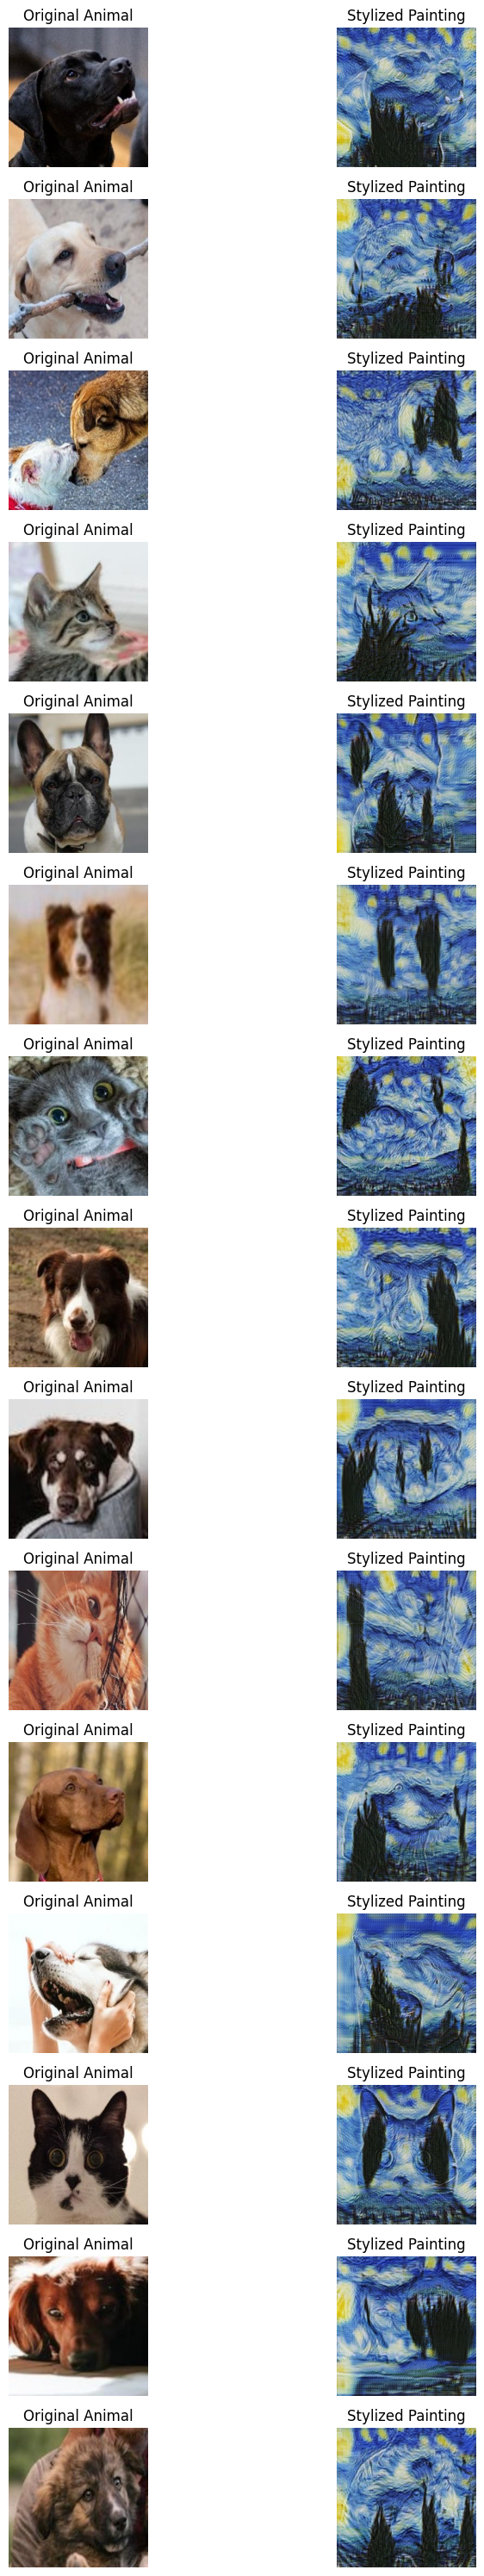

In [ ]:
# number of samples to show
num_samples = 10

plt.figure(figsize=(10, num_samples * 2))
for i, img_name in enumerate(generated_images[:num_samples]):
    real_img_name = img_name.replace("fake_B", "real_A")  # get the original animal image
    real_img_path = os.path.join(result_folder, real_img_name)
    fake_img_path = os.path.join(result_folder, img_name)

    # load images
    real_img = Image.open(real_img_path)
    fake_img = Image.open(fake_img_path)

    # show real image
    plt.subplot(num_samples, 2, 2 * i + 1)
    plt.imshow(real_img)
    plt.axis("off")
    plt.title("Original Animal")

    # show generated style-transferred image
    plt.subplot(num_samples, 2, 2 * i + 2)
    plt.imshow(fake_img)
    plt.axis("off")
    plt.title("Stylized Painting")

plt.tight_layout()
plt.show()

## Conclusion:

- First setup:
Epochs: 25, Epochs_Decay: 25 -> it will gradually decresing the learning rate to prevent sudden weight changes.
- Second setup: More training epochs, without decay: enhance style adaptation but increase the risk of overfitting, making the style more dominant
- Third setup: Training only with one painting will lead to overfitting to a single style. The output looks so similar and have a lack diversity.
- Higher lambda_A and lambda_B will have a strong cycle consistencym preserving original image details while still applying sylization.
- Lower lambda values make the model focus more on style transformation, potentially leading to loss of pet facial structure and details.
- A balanced approach is needed, combining enough training epochs, learning rate decay, and lambda values for both strong stylization and content preservation.